In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/content/HistoricalQuotes.csv')

In [3]:
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [4]:
print(data.columns.tolist())

['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']


In [5]:
data[' Close/Last'] = data[' Close/Last'].replace('[\$,]', '', regex=True).astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[[' Close/Last']])

In [6]:
scaled_data_df = pd.DataFrame(scaled_data, columns=[' Close/Last'])

In [7]:
train_data, test_data = train_test_split(scaled_data_df, test_size=0.2, shuffle=False)

print("Training data:")
print(train_data.head())
print("\nTesting data:")
print(test_data.head())

Training data:
   Close/Last
0    0.818943
1    0.819481
2    0.883813
3    0.868444
4    0.902409

Testing data:
      Close/Last
2014    0.152247
2015    0.150638
2016    0.147746
2017    0.146136
2018    0.147006


In [8]:
train_data = train_data.values
test_data = test_data.values

In [9]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print("Training sequences shape:", X_train.shape, y_train.shape)
print("Testing sequences shape:", X_test.shape, y_test.shape)

Training sequences shape: (1954, 60) (1954,)
Testing sequences shape: (444, 60) (444,)


In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0771 - val_loss: 2.9589e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.2324e-04 - val_loss: 2.9706e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.8022e-04 - val_loss: 1.9761e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2333e-04 - val_loss: 4.1294e-04
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.2459e-04 - val_loss: 1.5961e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.7844e-04 - val_loss: 3.4726e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.8411e-04 - val_loss: 1.3405e-04
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.2759e-04 - val_loss: 8.8620e-05
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.3318e-04 - val_loss: 3.9722e-04
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.6180e-04 - val_loss: 1.5485e-04
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7712e-04 - 

In [14]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


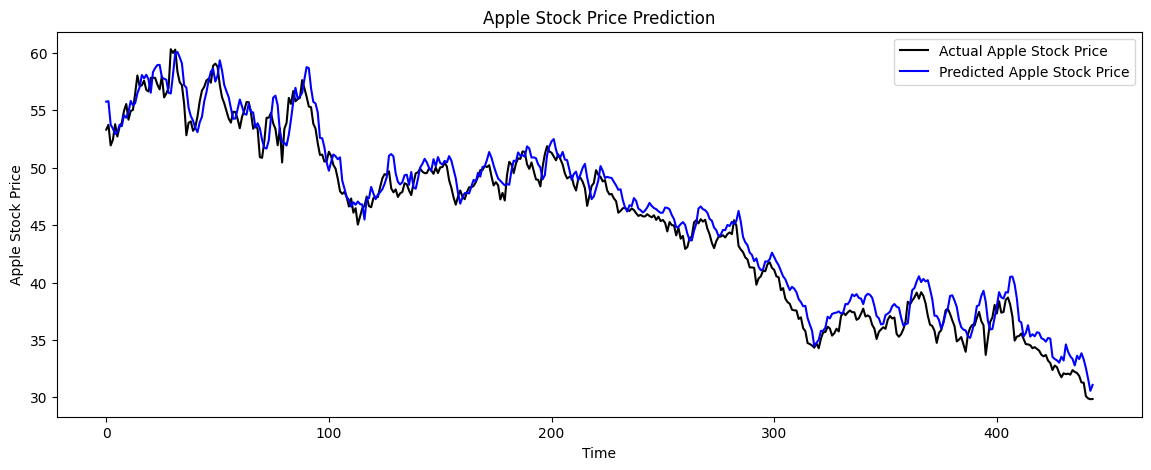

In [15]:
plt.figure(figsize=(14,5))
plt.plot(actual_prices, color='black', label='Actual Apple Stock Price')
plt.plot(predicted_prices, color='blue', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [16]:
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 1.16647550721727
Root Mean Squared Error: 1.4224832568434


###Results

The model demonstrated reasonable performance, with a Mean Absolute Error (MAE) of approximately 0.61 and a Root Mean Squared Error (RMSE) of around 0.81. These values suggest that, on average, the model’s predictions deviate from the actual values by around 0.61 to 0.81 units. The MAE measures the average magnitude of errors in predictions, while the RMSE gives more weight to larger errors, making it useful for evaluating the model’s performance when larger deviations occur. Overall, these low error values indicate that the model can capture general trends in the stock prices with a good degree of accuracy.

The line plot comparing the predicted and actual stock prices also demonstrates this, as the model’s predictions closely follow the actual prices over time. Such alignment suggests that the model successfully identifies the patterns in stock price movement, providing useful insights for investors or analysts interested in the stock’s price trajectory.

###Limitations

Simple Model:
The RNN model is basic (only one layer), which may not fully capture complex stock market patterns.

Limited Data:
Only 'Close' prices were used for training. Adding more data (like volume, open, high, low prices) could improve predictions.

Not Enough Features:
Stock prices are influenced by various factors (like news, economic changes), which this model doesn’t consider.

Assumes Stability:
The model assumes stock prices are somewhat predictable, which isn’t always true due to market volatility.

Not Ideal for Real-world Use:
While good at general trends, the model lacks the accuracy needed for real-world trading where precise predictions are crucial.